# Setup

In [1]:
import sys
sys.path.append('src')
import numpy as np
import generalized_langevin as gle
import codetimer as ct
import matplotlib.pyplot as plt
%matplotlib notebook
%load_ext autoreload
%autoreload 2

---

# Langevin Impulse-based integrator

The Langevin Impulse (LI) integrator is the "SD" (stochastic dynamics) integrator used in GROMACS (and also GROMOS). It is an "impulsive Langevin" extension to the familiar leap-frog algorithm. Though the authors state at the outset that they seek an algorithm that is of the same order of accuracy as the Verlet-type algorithms, though it's not clear whether this stochastic algorithm is truly correct to second order in the timestep, $\mathcal{O}(\Delta t^2)$.

Primary reference: [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876)

See also: [R. D. Skeel & J. A. Izaguirre (2002), Mol. Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/0026897021000018321)

---

## Assumed dynamical form

The generalized Langevin dynamics (GLD) equation of motion is represented in the extended/auxiliary variable formalism by the following set of coupled, first-order SDEs:

$$
\dot{x} = v(t)
$$

$$
\dot{v} = \frac{1}{m}F(x(t)) - \frac{1}{m}\sum_{k=1}^N \sigma_k(t) - \frac{c_0}{m}\:\! v(t) + \hat{\xi}_0(t),
$$

$$
\dot{\sigma}_k = -\frac{1}{\tau_k}\sigma_k(t) - \frac{c_k}{\tau_k}v(t) + \frac{1}{\tau_k}\hat{\xi}_k(t)
$$

where $x$, $v$, and $m$ are, respectively, the main particle's position, velocity and mass, $c_0 = \sum c_k$ with $\gamma_0 = c_0/m = 1/\tau_0$ being the collision frequency for the main particle, $\gamma_k = c_k/m = 1/\tau_k$ is the collision frequency for auxiliary particle $k$, and $\hat{\xi}_0$ and $\hat{\xi}_k$ are thermal noise terms for the main and $k^\text{th}$ particle, respectively. There are $N$ auxiliary particles, each subject to an independent noise process, $\xi_k$; $\hat{\xi}_0$ and $\hat{\xi}_k$ describe $N+1$ zero-mean, white Gaussian noise processes with autocorrelations given by

$$
\left\langle\xi_0(t)\xi_0(t')\right\rangle = \sum_{k=1}^N \frac{2k_BT c_k}{m}\delta(t-t').
$$

$$
\left\langle\xi_k(t)\xi_k(t')\right\rangle = \frac{2k_BT c_k}{\tau_k^2}\delta(t-t').
$$

Since $\xi_0$ is calculated from a weighted sum of the $\xi_k$, the $N$ auxiliary noise processes, there are $N$ independent stochastic samples required per timestep.

## Numerical discretization


### Langevin Impulse approach

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

$$
v_\text{LF}^{n+1/2} = v^{n-1/2} + \frac{\Delta t}{m}\left[F(x^n) - \sum_{k=1}^N \sigma_k^n\right]
$$

$$
\Delta v = -(1-\theta_0)\:\! v_\text{LF}^{n+1/2} + \sqrt{(1-\theta_0^2)\:\!\frac{k_BT}{m}} \,\mathcal{W}_0^n
$$

$$
x^{n+1} = x^n + \Delta t\left(v_\text{LF}^{n+1/2} + \frac{1}{2}\Delta v\right)
$$

$$
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!c_k v_\text{LF}^{n+1/2} + \sqrt{\frac{(1-\theta_k^2)}{\tau_k}c_k k_BT} \,\mathcal{W}_k^n
$$

$$
v^{n+1/2} = v_\text{LF}^{n+1/2} + \Delta v
$$

where

$$
\theta_0 = e^{-c_0 \Delta t/m} = e^{-\Delta t/\tau_0} = e^{-\gamma_0 \Delta t} \qquad \text{and} \qquad \theta_k = e^{-\Delta t/\tau_k}.
$$

Note that $\mathcal{W}_k^n$ is a zero-mean, unit variance white noise process sampled independently of the other noises at each timestep, $n$, while $\mathcal{W}_0^n$ is a weighted sum of the $N$ independent white noises. Also note that $v_\text{LF}$ is the usual MD velocity update for the leap-frog scheme, which now includes the "auxiliary forces", $\sigma_k$. The _effective collision frequency_<sup>[2](#footnote2)</sup> of particle $k$ is given by $1/\tau_k$, and $0 \leq (1 -\theta_k) \leq 1$ is a _velocity reduction factor_ that scales the impulsive application of friction and noise.

**Notes**:

<a name="footnote1">1</a>: For some reason, the [GROMACS manual](http://manual.gromacs.org/documentation/2018/manual-2018.pdf) specifies the noise term with $\sqrt{(1-\alpha^2)k_BT/m}$ rather than $\sqrt{\alpha(2-\alpha)k_BT/m}$ as specified in [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876). The GROMACS definition makes somewhat _less_ sense to me when considering the series expansion in powers of small $\gamma\Delta t$, though I'm not sure whether there's simply a typo in the manual or they're using a different definition. For the latter expression ($\sqrt{\alpha(2-\alpha)k_BT/m}$, where $\alpha = 1 - \exp(-\gamma_0\Delta t)$), it can be easily seen that $(1-\theta_0) = \alpha$ and $(1-\theta_0^2) = \alpha(2-\alpha)$

<a name="footnote2">2</a>: From what I currently understand, $\gamma_0 = 1/\tau_0$ is the collision frequency that results from discretizing the noise and friction in the system using $(1-\theta_0)$. It makes sense, however, that when $\Delta t/\tau_0 \ll 1$, we have $(1-\theta_0) = \Delta t/\tau_0 + \mathcal{O}(\Delta t^2)$ and $(1-\theta_0^2) = 2\Delta t/\tau_0$, which leads to

$$
\Delta v = -\frac{\Delta t}{\tau_0}\:\! v_\text{LF}^{n+1/2} + \sqrt{\frac{2 k_BT\Delta t}{\tau_0 m}} \,\mathcal{W}_0^n
$$

---
## Test Langevin Impulse integration

In [2]:
PI = np.pi
NA = 6.022E23

N   = 13        # number of auxiliary particles
nu0 = 1000.0
b   = 5.0
Cb  = 1.78167

tau0 = 1./nu0

eta = 1.0042e-3*NA*1e3*1e-3*1e-9*1e-12   # dynamic viscosity @ 293 K  [kg/m/s = Pa*s to kDa/nm/ps]
rhof = 1.0*NA*(1.e-7)**3*1e-3       # fluid density     [g/cm^3 to kDa/nm^3]
rhop = 1.0*NA*(1.e-7)**3*1e-3       # particle density  [g/cm^3 to kDa/nm^3]
R = 10.0                           # radius of sphere  [nm]

B = ( 3*R**2*(PI*eta*rhof)**0.5 ) * Cb
tauk = np.fromfunction(lambda k: tau0*b**k, (N,), dtype=np.float64)
ck   = B*tauk/tauk**(1.5)

In [3]:
print 'tau0:', tau0
print 'eta: ', eta
print 'rhof:', rhof
print 'rhop:', rhop
print 'B:   ', B

print 'tauk:', tauk
print 'ck:  ', ck

tau0: 0.001
eta:  0.60472924
rhof: 0.6022
rhop: 0.6022
B:    571.708064114
tauk: [1.00000000e-03 5.00000000e-03 2.50000000e-02 1.25000000e-01
 6.25000000e-01 3.12500000e+00 1.56250000e+01 7.81250000e+01
 3.90625000e+02 1.95312500e+03 9.76562500e+03 4.88281250e+04
 2.44140625e+05]
ck:   [1.80789964e+04 8.08517298e+03 3.61579928e+03 1.61703460e+03
 7.23159856e+02 3.23406919e+02 1.44631971e+02 6.46813838e+01
 2.89263942e+01 1.29362768e+01 5.78527885e+00 2.58725535e+00
 1.15705577e+00]


In [9]:
gli_sim.Xout.close()
gli_sim.Vout.close()
gli_sim.Sout.close()
gli_sim = gle.GLEParticle(filename='data/ELI_newtest', method='ELI',
                         N=N, D=3, T=1, dt=0.001,
                         R=R, rhop=rhop, rhof=rhof, eta=eta, tau0=tau0,
                         tauk=tauk, ck=ck, k=0.0)

tau0:   0.001
c0:     32704.275638154144
theta0: 0.36787944117144233
alpha0: 20.79260345367298
sigma0: 15.333141592239274
Settings parameters for ELI integrator
tau0:   0.001
c0:     32704.275638154144
tauk:   [1.00000000e-03 5.00000000e-03 2.50000000e-02 1.25000000e-01
 6.25000000e-01 3.12500000e+00 1.56250000e+01 7.81250000e+01
 3.90625000e+02 1.95312500e+03 9.76562500e+03 4.88281250e+04
 2.44140625e+05]
ck:     [1.80789964e+04 8.08517298e+03 3.61579928e+03 1.61703460e+03
 7.23159856e+02 3.23406919e+02 1.44631971e+02 6.46813838e+01
 2.89263942e+01 1.29362768e+01 5.78527885e+00 2.58725535e+00
 1.15705577e+00]


[autoreload of force failed: Traceback (most recent call last):
  File "/Users/sseyler/miniconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "src/force.py", line 38
    def GWN_multi(self, σ):
                        ^
SyntaxError: invalid syntax
]


In [5]:
with ct.Timer(unit='secs') as t:
    gli_sim.run(nsteps=10000, tmpsize=10000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 2000 (20.0% complete)

/Users/sseyler/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
src/GLE_integrator.py:139: RuntimeWarning: invalid value encountered in add
  return X0 + (Vd + 0.5*Vi)*self.dt
src/GLE_integrator.py:147: RuntimeWarning: overflow encountered in multiply
  return self.thetak*Sk0 + self.omtkck*Vi.T + xik
src/GLE_integrator.py:155: RuntimeWarning: invalid value encountered in add
  return Vd + Vi


Step 10000 (100.0% complete) – elapsed time: 1.3 s


In [6]:
gli_sim.positions

x1            y1            z1
1.0      0.000000e+00  0.000000e+00  0.000000e+00
2.0     -1.769090e-04  9.543194e-04 -2.288799e-03
3.0      3.580465e-05 -4.587804e-03  2.580568e-02
4.0     -3.848044e-03  7.997830e-02 -3.713641e-01
5.0      4.357956e-02 -1.128006e+00  5.296618e+00
6.0     -6.456616e-01  1.609111e+01 -7.550596e+01
7.0      9.174937e+00 -2.293921e+02  1.076425e+03
8.0     -1.308370e+02  3.270246e+03 -1.534562e+04
9.0      1.865181e+03 -4.662097e+04  2.187689e+05
10.0    -2.659027e+04  6.646336e+05 -3.118793e+06
11.0     3.790738e+05 -9.475090e+06  4.446186e+07
12.0    -5.404117e+06  1.350779e+08 -6.338531e+08
13.0     7.704169e+07 -1.925686e+09  9.036280e+09
14.0    -1.098315e+09  2.745279e+10 -1.288222e+11
15.0     1.565770e+10 -3.913699e+11  1.836503e+12
16.0    -2.232178e+11  5.579413e+12 -2.618139e+13
17.0     3.182218e+12 -7.954072e+13  3.732448e+14
18.0    -4.536605e+13  1.133941e+15 -5.321019e+15
19.0     6.467434e+14 -1.616559e+16  7.585703e+16
20.0    -9.220044e+15  2.304584e+17 -1.081426e+18
21.0     1.314420e+17 -3.285441e+18  1.541693e+19
22.0    -1.873851e+18  4.683761e+19 -2.197855e+20
23.0     2.671383e+19 -6.677221e+20  3.133286e+21
24.0    -3.808352e+20  9.519119e+21 -4.466846e+22
25.0     5.429229e+21 -1.357056e+23  6.367985e+23
26.0    -7.739969e+22  1.934634e+24 -9.078270e+24
27.0     1.103418e+24 -2.758035e+25  1.294208e+26
28.0    -1.573045e+25  3.931886e+26 -1.845037e+27
29.0     2.242551e+26 -5.605339e+27  2.630305e+28
30.0    -3.197005e+27  7.991033e+28 -3.749792e+29
...               ...           ...           ...
9971.0            NaN           NaN           NaN
9972.0            NaN           NaN           NaN
9973.0            NaN           NaN           NaN
9974.0            NaN           NaN           NaN
9975.0            NaN           NaN           NaN
9976.0            NaN           NaN           NaN
9977.0            NaN           NaN           NaN
9978.0            NaN           NaN           NaN
9979.0            NaN           NaN           NaN
9980.0            NaN           NaN           NaN
9981.0            NaN           NaN           NaN
9982.0            NaN           NaN           NaN
9983.0            NaN           NaN           NaN
9984.0            NaN           NaN           NaN
9985.0            NaN           NaN           NaN
9986.0            NaN           NaN           NaN
9987.0            NaN           NaN           NaN
9988.0            NaN           NaN           NaN
9989.0            NaN           NaN           NaN
9990.0            NaN           NaN           NaN
9991.0            NaN           NaN           NaN
9992.0            NaN           NaN           NaN
9993.0            NaN           NaN           NaN
9994.0            NaN           NaN           NaN
9995.0            NaN           NaN           NaN
9996.0            NaN           NaN           NaN
9997.0            NaN           NaN           NaN
9998.0            NaN           NaN           NaN
9999.0            NaN           NaN           NaN
10000.0           NaN           NaN           NaN

[10000 rows x 3 columns]

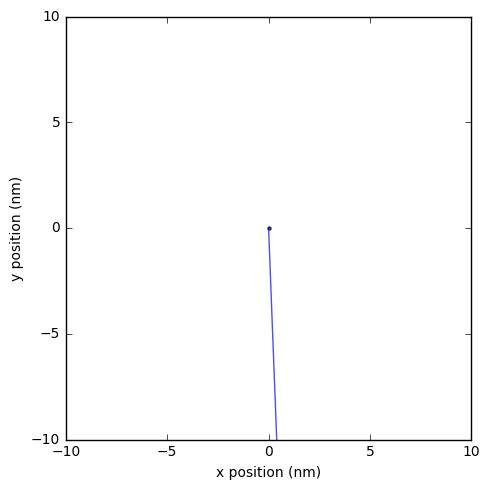

In [50]:
plt.clf()
fig, ax = gli_sim.quick_plot(projection=None, start=0, end=None, skip=100,
                              xlim=[-10,10], ylim=[-10,10], zlim=[-10,10],
                              figsize=5.0, ptsize=5)

---

# Grønbech-Jensen–Farago integrator

This integrator is described by the authors as "a revision to the well known Störmer–Verlet algorithm for simulating second order differential equations. The revision addresses the inclusion of linear friction with associated stochastic noise, and we analytically demonstrate that the new algorithm correctly reproduces diffusive behavior of a particle in a flat potential." The algorithm is correct to second order in the timeste, $\mathcal{O}(\Delta t^2)$.

Reference: [N. Grønbech-Jensen  & O. Farago (2013). Mol.Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/00268976.2012.760055)

---

## Assumed dynamical form

The equation of motion is a second-order SDE of the Langevin type:

$$
\dot{x} = v(t)
$$

$$
m\dot{v} = F(x(t)) - m\:\!\gamma\:\! v(t) + \beta(t),
$$

where $m$ is the particle mass, $\gamma = \zeta/m$ is the collision frequency, $\zeta$ is the usual friction coefficient, and the noise autocorrelation is given by

$$
\left\langle\beta(t)\beta(t')\right\rangle = 2m\:\!\gamma \:\!k_BT\:\!\delta(t-t').
$$

## Numerical discretization

First, we note that the autocorrelation is expressed in terms of the time step (just like in the first-order BBK algorithm),

$$
\left\langle\beta^n\beta^m\right\rangle = 2m\:\!\gamma \:\!k_BT\Delta t\:\!\delta_{nm},
$$

which will be used in the expressions that follow. The numerical algorithm is given by

$$
x^{n+1} = x^n + \alpha\Delta t\:\! v^n + \frac{ \alpha\Delta t^2}{2m}F(x^n) + \frac{\alpha\Delta t}{2m}\beta^{n+1}
$$

$$
v^{n+1} = v^n + \frac{\Delta t}{2m}\left[F\left(x^n\right) + F\left(x^{n+1}\right)\right] - \gamma\left(x^{n+1} - x^n\right) + \frac{1}{m}\beta^{n+1}
$$

where

$$
\alpha = \frac{1}{1 + \frac{\gamma\Delta t}{2}},
$$

where the timestep must be sufficiently small to satisfy $\gamma\Delta t < 2$. Using the substitution $F(x^n) = F^n$ along with $\beta^n = \sqrt{2m\:\!\gamma \:\!k_BT\Delta t}\:\! \mathcal{W}^n$, where $\mathcal{W}$ is a zero-mean, unit-variance white noise, we can rewrite the above discretization as

$$
\Delta x = \alpha\Delta t\left(v^n + \frac{\Delta t}{2m}F^n + \frac{1}{2}\sqrt{\frac{2\gamma\:\!k_BT \Delta t}{m}}\,\mathcal{W}^{n+1}\right)
$$

$$
x^{n+1} = x^n + \Delta x
$$

$$
v^{n+1} = v^n - \gamma\Delta x + \frac{\Delta t}{2m}\left(F^n + F^{n+1}\right) + \sqrt{\frac{2\gamma\:\!k_BT\Delta t}{m}}\,\mathcal{W}^{n+1}
$$

---
## Test Grønbech-Jensen–Farago integration

In [5]:
gjf_sim = langevin.LangevinParticle(filename='data/GJF_newtest', method='GJF',
                            N=1, D=3, T=1, m=100.0, gamma=1.0, k=0.0, dt=1.0)

Settings parameters for GJF integrator


In [6]:
with ct.Timer(unit='secs') as t:
    gjf_sim.run(nsteps=100000, tmpsize=100000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 100000 (100.0% complete) – elapsed time: 2.8 s


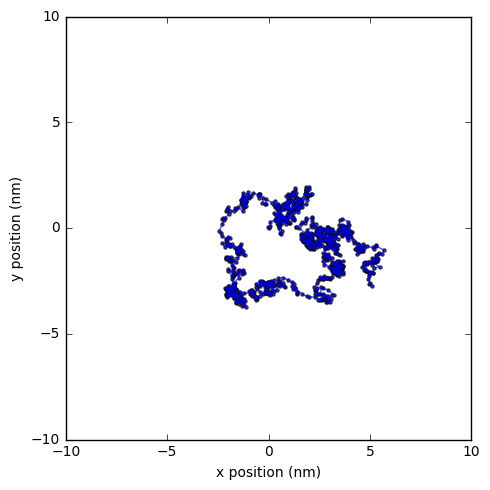

In [7]:
plt.clf()
fig, ax = gjf_sim.quick_plot(projection=None, start=0, end=None, skip=100,
                              xlim=[-10,10], ylim=[-10,10], zlim=[-10,10],
                              figsize=5.0, ptsize=5)

---

---

---

### T = 0 | N = 8

In [2]:
sim31_8_0 = md.MD(outfile='traj3-1_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim32_8_0 = md.MD(outfile='traj3-2_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim33_8_0 = md.MD(outfile='traj3-3_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim34_8_0 = md.MD(outfile='traj3-4_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim35_8_0 = md.MD(outfile='traj3-5_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim36_8_0 = md.MD(outfile='traj3-6_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)

### T = 300 | N = 8

In [3]:
sim31_8_300 = md.MD(outfile='traj3-1_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim32_8_300 = md.MD(outfile='traj3-2_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim33_8_300 = md.MD(outfile='traj3-3_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim34_8_300 = md.MD(outfile='traj3-4_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim35_8_300 = md.MD(outfile='traj3-5_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim36_8_300 = md.MD(outfile='traj3-6_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)

## Run simulations

### T = 0 K , N = 8

# 0

In [4]:
with ct.Timer(unit='secs') as t:
    sim31_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 130000 (13.0% complete) – elapsed time: 13.4 s
Step 130000 (13.0% complete) – elapsed time: 15.9 s
Step 130000 (13.0% complete) – elapsed time: 14.4 s
Step 130000 (13.0% complete) – elapsed time: 14.6 s
Step 130000 (13.0% complete) – elapsed time: 15.6 s
Step 130000 (13.0% complete) – elapsed time: 16.2 s


### T = 300 K , N = 8

# 300

In [5]:
with ct.Timer(unit='secs') as t:
    sim31_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 420000 (42.0% complete) – elapsed time: 45.7 s
Step 230000 (23.0% complete) – elapsed time: 24.6 s
Step 540000 (54.0% complete) – elapsed time: 59.3 s
Step 430000 (43.0% complete) – elapsed time: 49.8 s
Step 340000 (34.0% complete) – elapsed time: 37.7 s
Step 680000 (68.0% complete) – elapsed time: 69.5 s


# Raw data

We can view the trajectory output directly. It's a pandas DataFrame stored persistently in HDF5 format.

# Plotting

## T = 0 K , N = 8

### XY plots

In [ ]:
s = 0
sim31_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)

### YZ plots

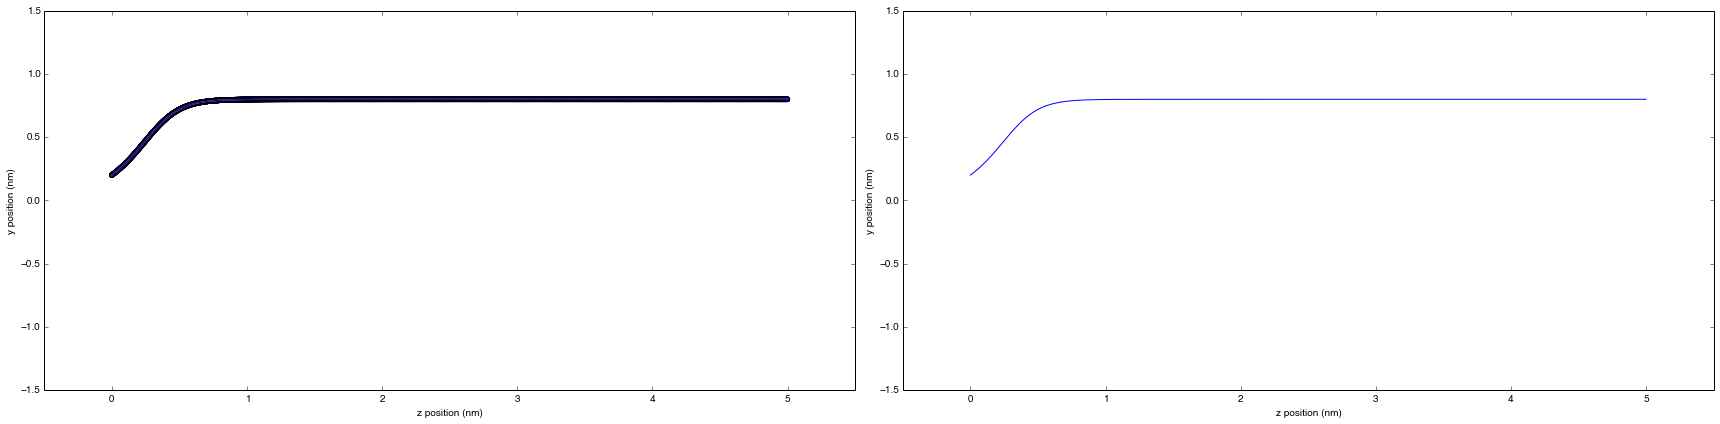

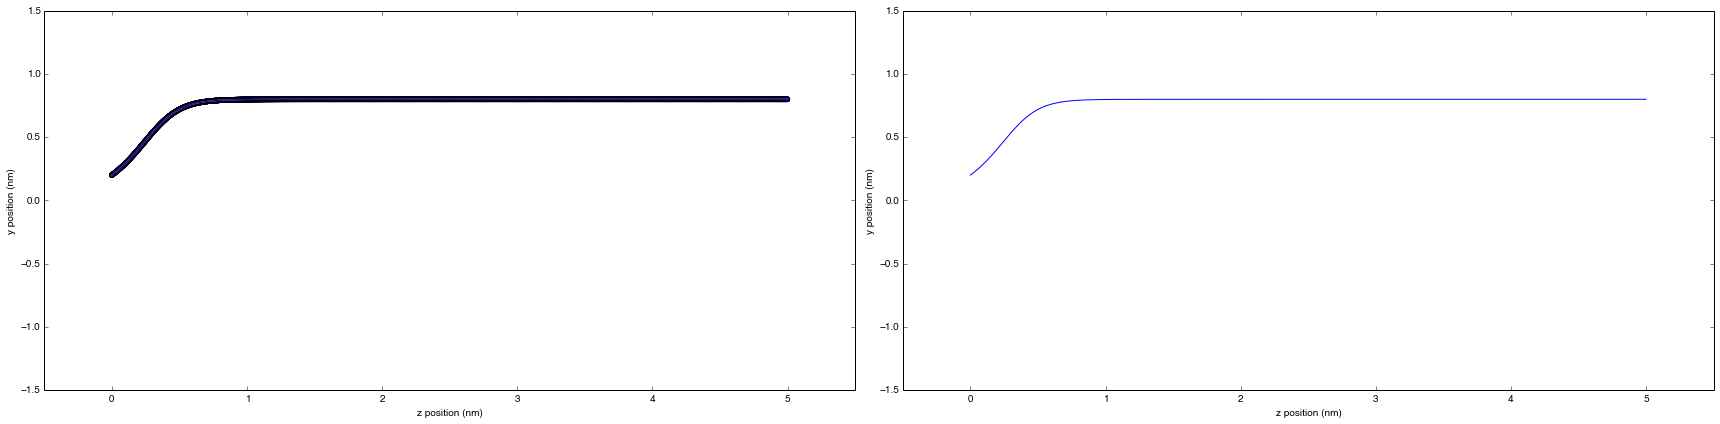

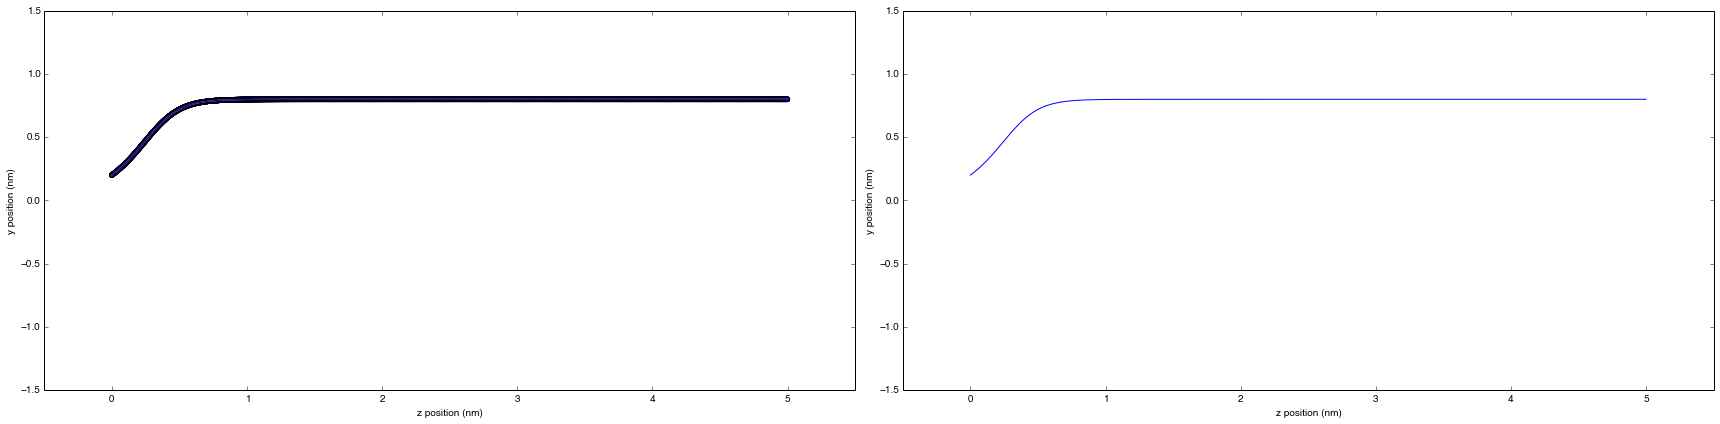

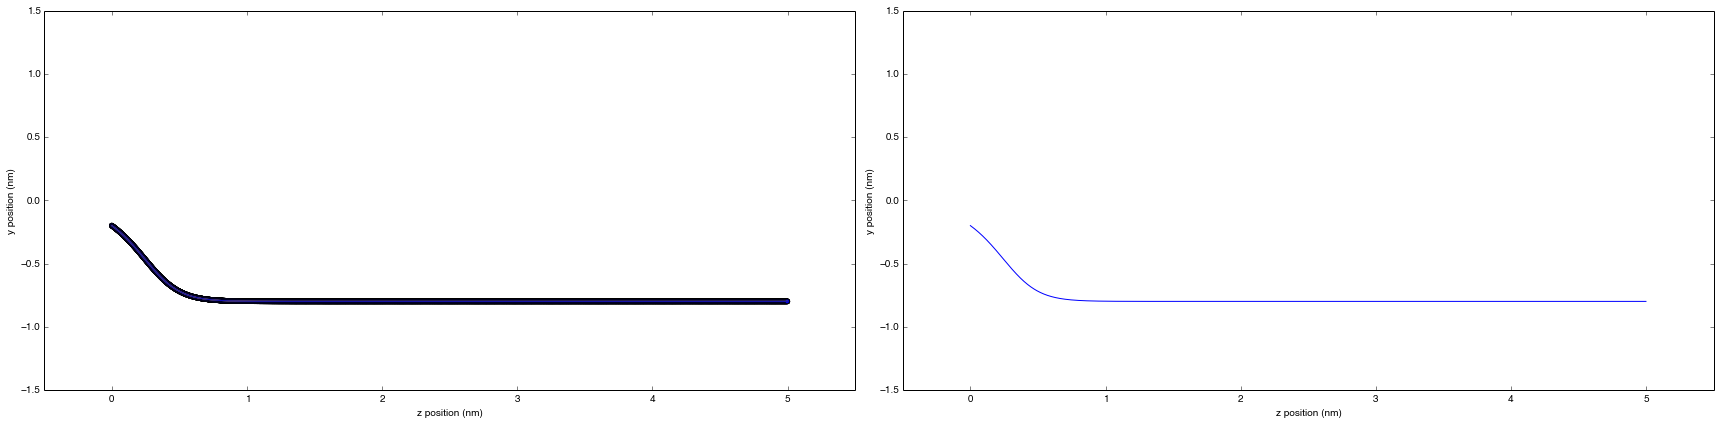

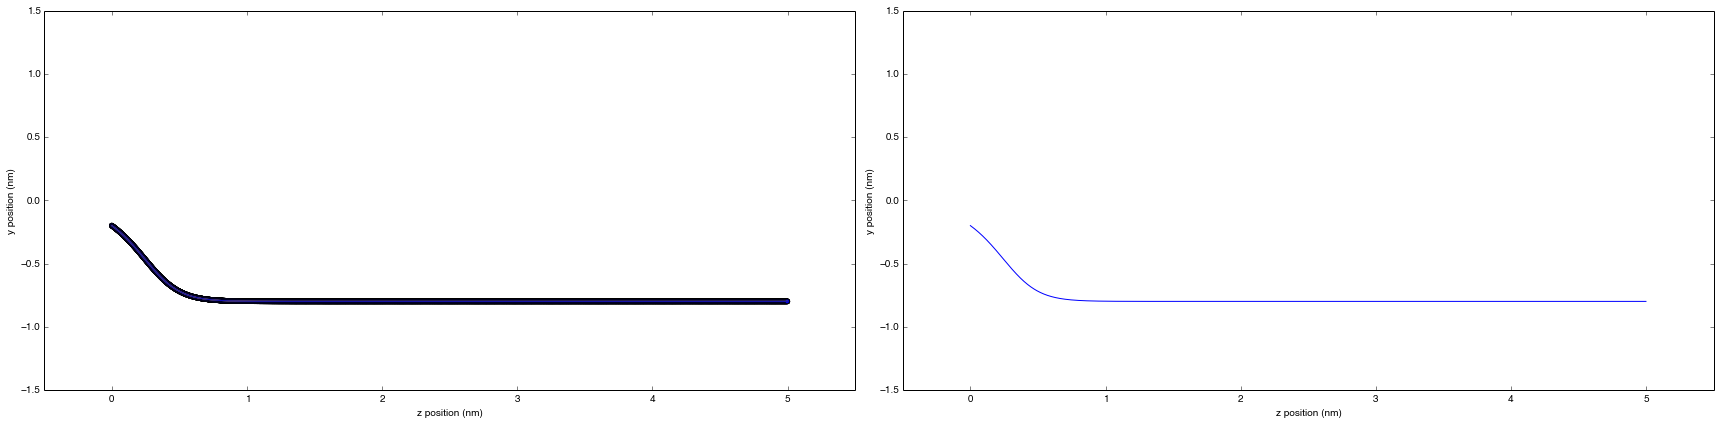

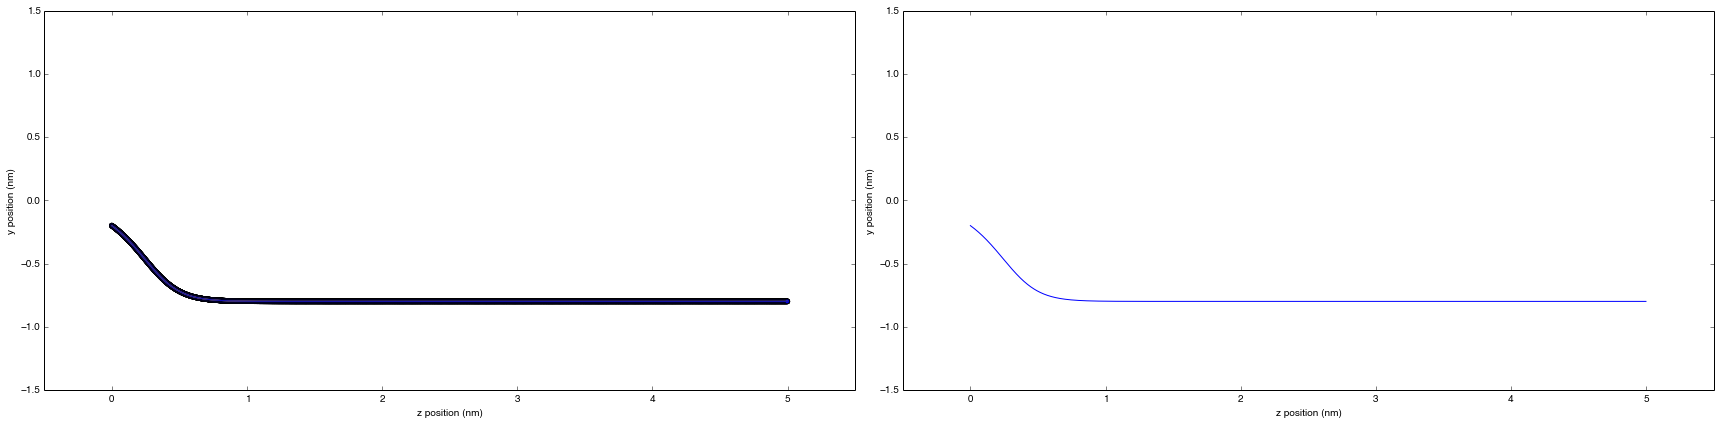

In [6]:
s = 0
sim31_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)

## T = 300 K , N = 8

### XY plots

In [ ]:
sim.plot_trajectories(projection='xy', skip=1000)

### YZ plots

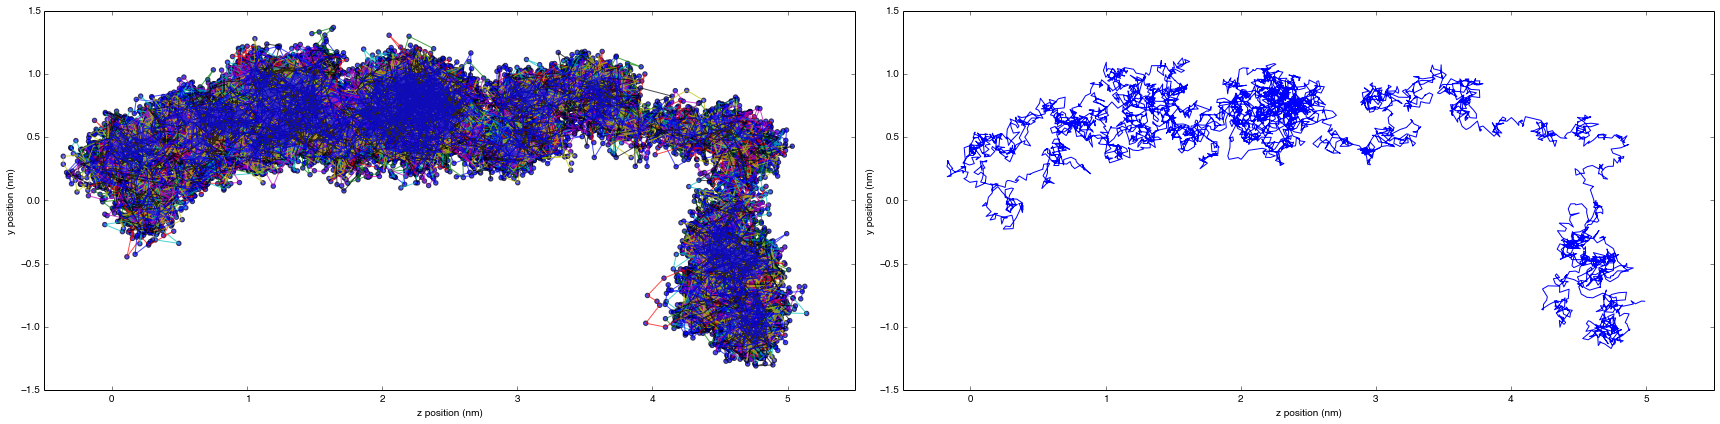

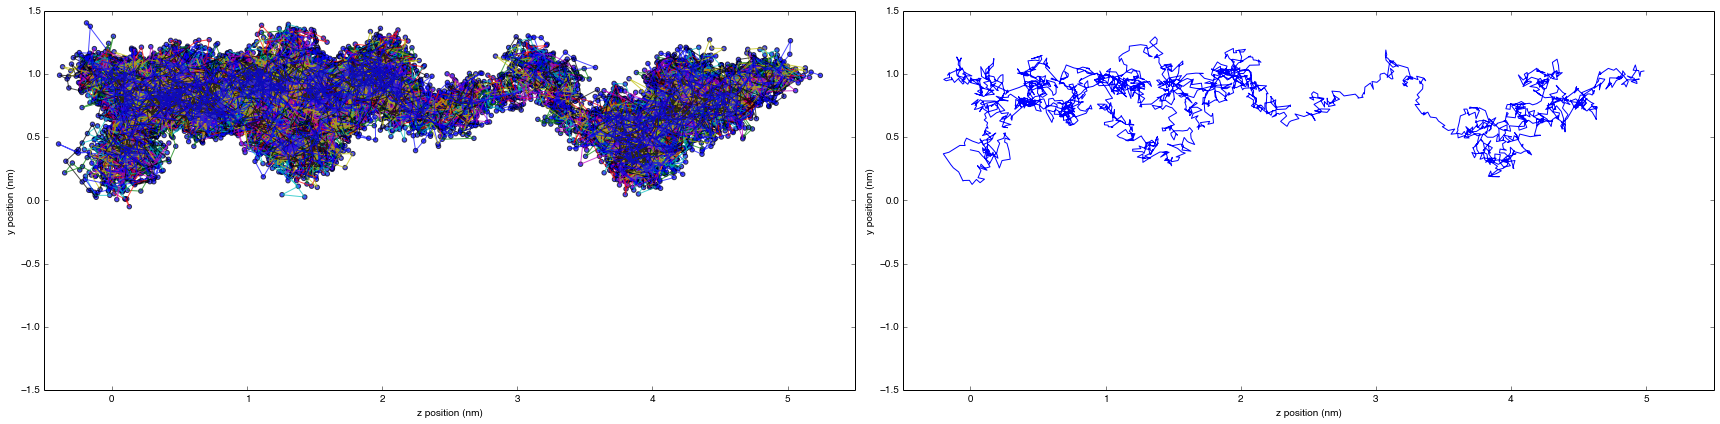

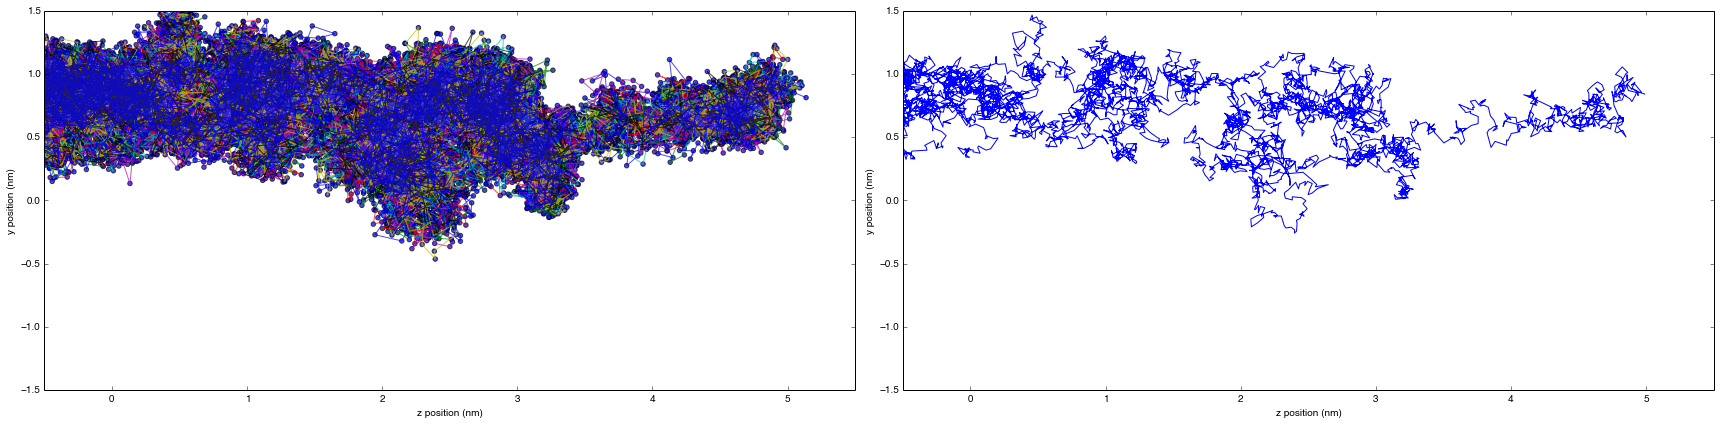

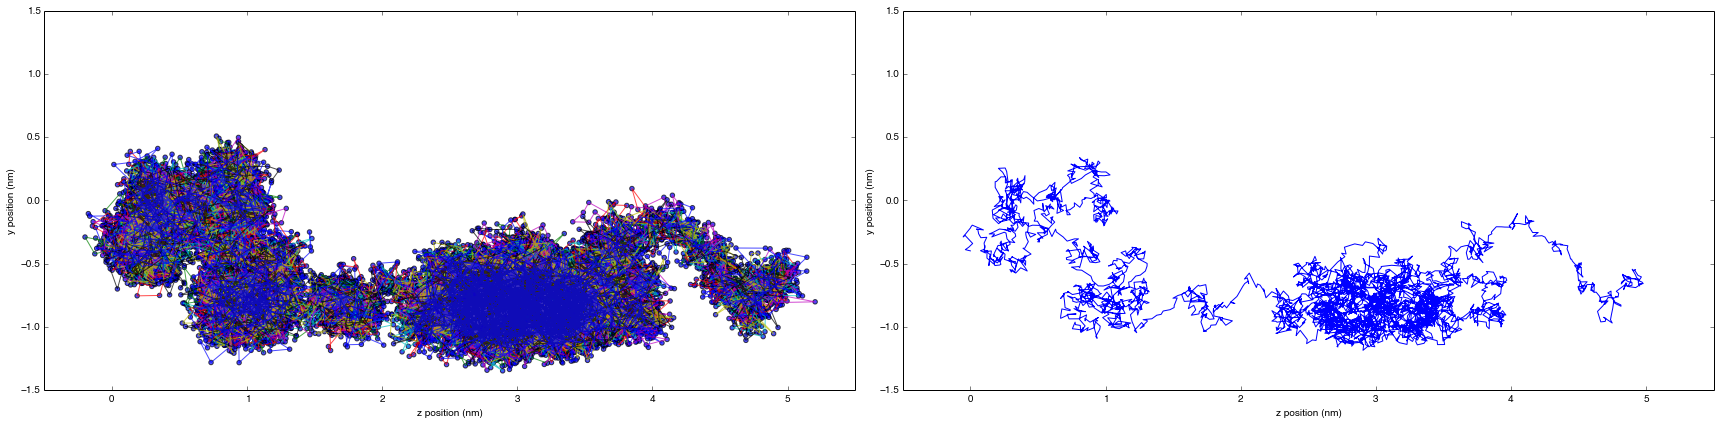

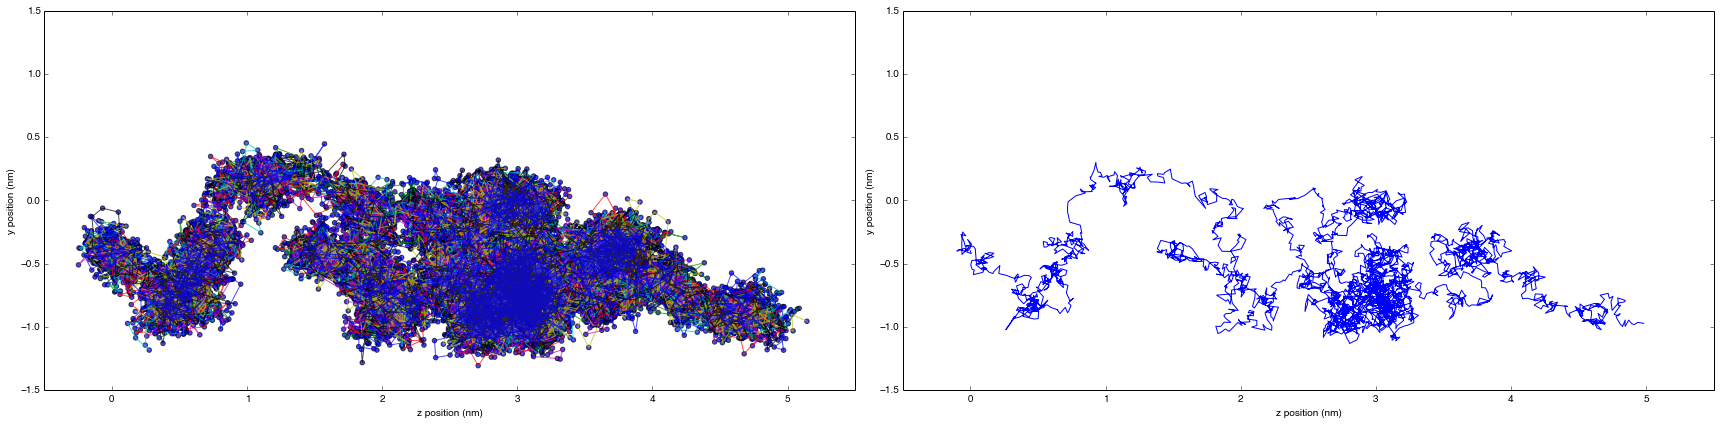

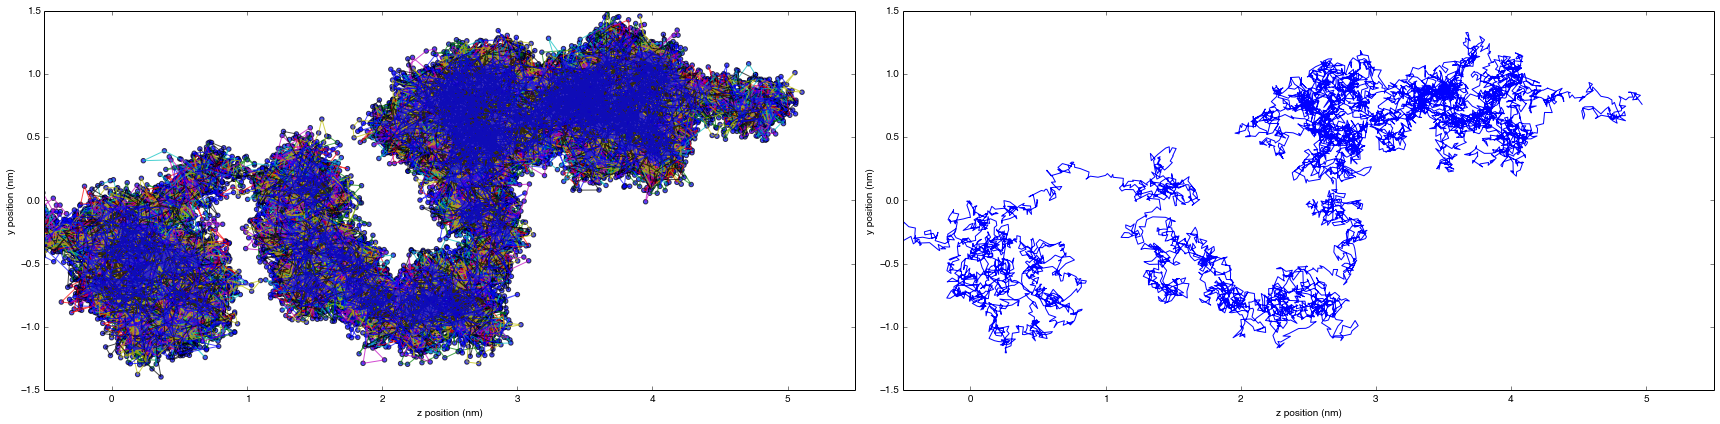

In [8]:
s=0
sim31_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)

In [68]:
simtest.compute_particle_size()

(array([ 0.22106883,  0.21892975,  0.21886752]),
 0.38040065270089218,
 0.21962203501782554,
 0.38961259711579105)

In [69]:
simtest2.compute_particle_size()

(array([ 0.22004685,  0.22021797,  0.22240095]),
 0.38259475816196803,
 0.22088858691080987,
 0.391798958433341)

In [10]:
sim31_8_0.compute_rog()

AttributeError: 'MD' object has no attribute 'compute_rog'